In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aerial-cactus-identification/train.zip
/kaggle/input/aerial-cactus-identification/sample_submission.csv
/kaggle/input/aerial-cactus-identification/train.csv
/kaggle/input/aerial-cactus-identification/test.zip


In [2]:
! cp -rf /kaggle/input/aerial-cactus-identification/train.csv -d /kaggle/working
! unzip -o /kaggle/input/aerial-cactus-identification/train.zip -d /kaggle/working
! unzip /kaggle/input/aerial-cactus-identification/test.zip -d /kaggle/working

Archive:  /kaggle/input/aerial-cactus-identification/train.zip
   creating: /kaggle/working/train/
  inflating: /kaggle/working/train/008bd3d84a1145e154409c124de7cee9.jpg  
  inflating: /kaggle/working/train/0090d921aeb53be7e3df6f4b0254c537.jpg  
  inflating: /kaggle/working/train/00e9930f89b5f94f90d0285632f25e9d.jpg  
  inflating: /kaggle/working/train/00e9d95c663af530b8769d37f92cb13a.jpg  
  inflating: /kaggle/working/train/0148bb4a295cf49c0169d69a4a63df7e.jpg  
  inflating: /kaggle/working/train/01506b63fb89b2bde4df0d1d63a3004b.jpg  
  inflating: /kaggle/working/train/015a4952d1ec690fd14c36d35395deec.jpg  
  inflating: /kaggle/working/train/01e30c0ba6e91343a12d2126fcafc0dd.jpg  
  inflating: /kaggle/working/train/0251debcce56e3e7fab5537a74761378.jpg  
  inflating: /kaggle/working/train/0290af70d02cbc47e66e4715e6f19ac5.jpg  
  inflating: /kaggle/working/train/02abf14275d208b1b43f220fa15519cb.jpg  
  inflating: /kaggle/working/train/02d8f310b2979172949fbcd8b52bafd4.jpg  
  inflating: 

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import keras


from keras.datasets import mnist
from sklearn.model_selection import train_test_split

print("tf version : ", tf.__version__)

# GPU test 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

tf version :  2.3.0
Found GPU at: /device:GPU:0


## Data extraction

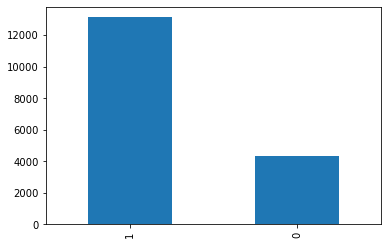

In [4]:
df = pd.read_csv('train.csv')
#df.has_cactus = np.where(df.has_cactus == 1, 'yes', 'no')
df.sample(3)
df.has_cactus.value_counts().plot.bar()

## Data Preprocessing

003519dd841a97ed16481fa0657df04d.jpg


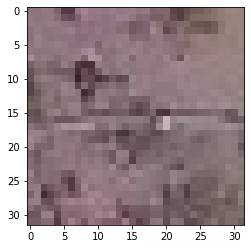

In [5]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical

filename = df.id[10]
print(filename)
image = load_img("./train/"+filename)

plt.imshow(image)

In [6]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=45,
    rescale=1./32,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1

)


#train_datagen = ImageDataGenerator()

In [8]:
BATCH_SIZE = 128
IMAGE_SIZE = (32,32)

INPUT_SHAPE=(32, 32, 3)
BATCH_SIZE=2**10

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, 
    directory="./train",
    x_col='id',
    y_col='has_cactus',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode="raw"
)


validation_generator = train_datagen.flow_from_dataframe(
    dataframe=validate_df, 
    directory="./train",
    x_col='id',
    y_col='has_cactus',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode="raw"
)

Found 14000 validated image filenames.
Found 3500 validated image filenames.


## Model:  less is better 



In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, AveragePooling2D


model = Sequential([
                    Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), activation='relu', input_shape=(32, 32, 3), padding="same"),
                    BatchNormalization(),
                    AveragePooling2D( pool_size=(3, 3)), 
                    Dropout(0.2),

#                     Conv2D(128, (4, 4), activation='relu',  padding="same"),
#                     BatchNormalization(),
#                     AveragePooling2D( pool_size=(2, 2)), 
#                     #Dropout(0.2),
    
        
#                     Conv2D(64, (2, 2), activation='relu',  padding="same"),
#                     BatchNormalization(),
#                     AveragePooling2D( pool_size=(2, 2)), 
#                     Dropout(0.3),
    
    
#                     Conv2D(32, (2, 2), activation='relu',  padding="same"),
#                     BatchNormalization(),
#                     AveragePooling2D( pool_size=(2, 2)), 
#                     Dropout(0.3),

                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dropout(0.45),
                    Dense(1, activation='sigmoid')
])


from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=4)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
callbacks = [earlystop]

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
average_pooling2d (AveragePo (None, 10, 10, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               819328    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [10]:
%%time
history = model.fit(
    train_generator, 
    epochs=30,
    validation_data=validation_generator,
    #validation_steps=validate_df.shape[0]//BATCH_SIZE,
    #steps_per_epoch=train_df.shape[0]//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/30
14/14 [==============================] - 14s 1s/step - loss: 0.5060 - accuracy: 0.7392 - val_loss: 0.9473 - val_accuracy: 0.2514
Epoch 2/30
14/14 [==============================] - 14s 988ms/step - loss: 0.2634 - accuracy: 0.8996 - val_loss: 0.7264 - val_accuracy: 0.3549
Epoch 3/30
14/14 [==============================] - 15s 1s/step - loss: 0.2023 - accuracy: 0.9264 - val_loss: 0.6545 - val_accuracy: 0.6451
Epoch 4/30
14/14 [==============================] - 14s 1s/step - loss: 0.2114 - accuracy: 0.9214 - val_loss: 0.6018 - val_accuracy: 0.7711
Epoch 5/30
14/14 [==============================] - 14s 965ms/step - loss: 0.1508 - accuracy: 0.9467 - val_loss: 0.4888 - val_accuracy: 0.7777
Epoch 6/30
14/14 [==============================] - 15s 1s/step - loss: 0.1514 - accuracy: 0.9454 - val_loss: 0.4897 - val_accuracy: 0.8126
Epoch 7/30
14/14 [==============================] - 14s 1s/step - loss: 0.1482 - accuracy: 0.9456 - val_loss: 0.7502 - val_accuracy: 0.4223
Epoch 8/30
14/

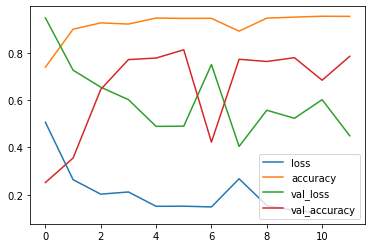

In [11]:
pd.DataFrame(history.history).plot()

### Test & submit

In [12]:
df = pd.DataFrame()
df['id'] = os.listdir('test')
df.head()

from keras.preprocessing import image_dataset_from_directory

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    df,
    "test", 
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


pred=model.predict(test_generator)


df['has_cactus'] =np.transpose(pred)[0] #np.argmax(pred, axis=-1)
df.sample(5)

Found 4000 validated image filenames.


,id,has_cactus
1956,fd9b78dbc8fbe0d116eeeff11298e81c.jpg,0.977173
3656,000940378805c44108d287872b2f04ce.jpg,0.988594
859,7404d7601891558f2cf559216ff10719.jpg,0.981097
1843,4eea117517b78f60e2b79120e5d128ff.jpg,0.981575
2677,69a2a55480402727c61a0a43c0426791.jpg,0.977481


In [13]:
pred

array([[0.9892097 ],
       [0.9827624 ],
       [0.9888087 ],
       ...,
       [0.98165256],
       [0.98742   ],
       [0.98375964]], dtype=float32)

In [14]:
np.transpose(pred)[0]

array([0.9892097 , 0.9827624 , 0.9888087 , ..., 0.98165256, 0.98742   ,
       0.98375964], dtype=float32)

In [15]:
df.has_cactus.max()

0.9923850297927856

In [16]:
submission = df.copy()
submission.to_csv('submission.csv', index=False)

In [17]:
! ls ../

input  lib  src  working


In [18]:
submission.head()

,id,has_cactus
0,3ce6aabd98a52aa87d5d7e644674509a.jpg,0.989210
1,dbf3f9dc09c80071a347863592ff4ea1.jpg,0.982762
2,ce03060470ef84f8faa3e75adbeffd49.jpg,0.988809
3,e0ab514b0b043f678225b47279c03765.jpg,0.981304
4,4cfaea3f7c0a9ef7bd23d190d6ad8527.jpg,0.980442


In [19]:
submission.has_cactus.describe()

count    4000.000000
mean        0.984943
std         0.004487
min         0.959963
25%         0.981347
50%         0.986315
75%         0.988666
max         0.992385
Name: has_cactus, dtype: float64

In [20]:
! rm -rf train test train.csv